In [37]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import cmath
import matplotlib.pyplot as plt

plt.style.use('seaborn')

/var/folders/_y/gpx6st7s77963mn1x58nrsf00000gn/T/ipykernel_21296/1792146053.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [38]:
cost_H = qml.PauliZ(0) + qml.PauliZ(1) + qml.PauliZ(2)
mixer_H = qml.PauliX(0) + qml.PauliX(1) + qml.PauliX(2)

In [39]:
wires = [0, 1, 2]

num_layers = 5

In [40]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_H)
    qaoa.mixer_layer(alpha, mixer_H)
    

def circuit(params):
    for w in wires:
        qml.Hadamard(w)
    qml.layer(qaoa_layer, num_layers, params[0], params[1])

In [41]:
dev = qml.device('default.qubit', wires=wires)

In [42]:
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_H)

In [43]:
opt = qml.GradientDescentOptimizer()
steps = 200

params = np.array([[0.5] * num_layers, [0.5] * num_layers], requires_grad=True)

for _ in range(steps):
    params = opt.step(cost_function, params)

In [44]:
@qml.qnode(dev)
def circuit_state(params):
    circuit(params)
    return qml.state()

In [45]:
np.round(circuit_state(params), decimals=5)

tensor([-0.+0.j,  0.+0.j,  0.-0.j, -0.-0.j,  0.+0.j, -0.-0.j, -0.+0.j,
        -1.-0.j], requires_grad=True)

In [46]:
def qaoa_layer_snapshot(gamma, alpha):
    qaoa.cost_layer(gamma, cost_H)
    qml.Snapshot()
    qaoa.mixer_layer(alpha, mixer_H)
    qml.Snapshot()

In [51]:
def circuit_snapshot(params):
    for w in wires:
        qml.Hadamard(w)
    qml.layer(qaoa_layer_snapshot, num_layers, params[0], params[1])

In [52]:
@qml.qnode(dev)
def circuit_state_snapshot(params):
    circuit_snapshot(params)
    return qml.state()

In [54]:
snaps = qml.snapshots(circuit_state_snapshot)(params)
# print(snaps)

In [55]:
amplitudes = np.zeros(2 * num_layers)
phases = np.zeros(2 * num_layers)

In [57]:
for i in range(2 * num_layers):
    solution_coef = snaps[i].reshape(2,2,2)[1,1,1]
    amplitudes[i] = np.real(solution_coef * np.conj(solution_coef))
    phases[i] = cmath.phase(solution_coef)

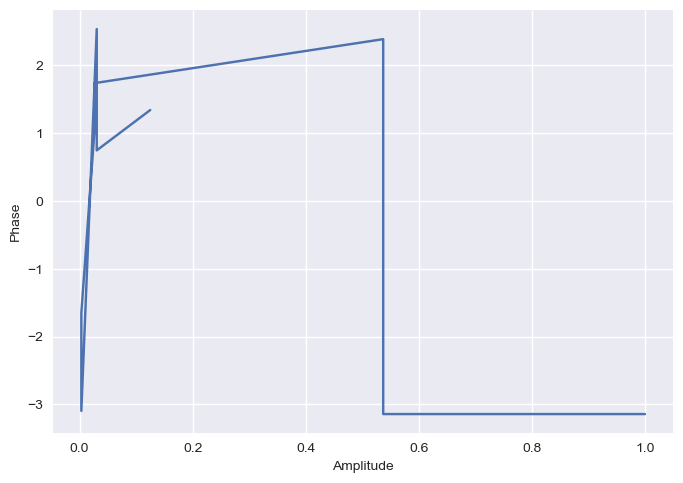

In [59]:
plt.plot(amplitudes, phases)
plt.ylabel('Phase')
plt.xlabel('Amplitude')
plt.show()